# HOMEWORK 4 - APPLIED ML

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

## 1. Propensity score matching

In [60]:
#loading data
lalonde_df = pd.read_csv('lalonde.csv').set_index('id')
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1.1. A naive analysis

In [61]:
treated = lalonde_df.loc[lalonde_df['treat'] == 1]
not_treated = lalonde_df.loc[lalonde_df['treat'] == 0]

In [62]:
treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [63]:
not_treated['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

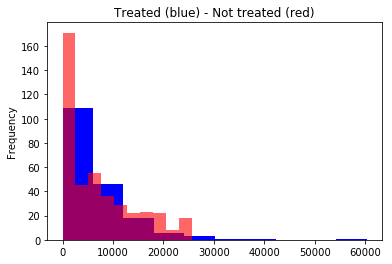

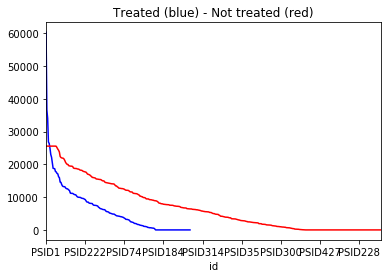

In [138]:
treated['re78'].plot(kind='hist',  color='blue', title='Treated (blue) - Not treated (red)')
not_treated['re78'].plot(kind='hist', color='red', alpha=0.6)
plt.show()

treated['re78'].sort_values(ascending=False).plot(color='blue', title='Treated (blue) - Not treated (red)')
not_treated['re78'].sort_values(ascending=False).plot(color='red')
plt.show()

Here a naive "researcher" might conclude that the treatment doesn't work. As the average income of the not treated group is higher than the the one form the treated group. But he/she could also conclude that if you are part of the few *lucky* ones in the treated group, you will have a much higher income than the people which are not getting the training.

### 1.2. A closer look at the data

We will now compare the distribution of real income values but this time for each year, ages and education level. Comparing the 1/0 values of the race, marriage and treatment does not make much sens.

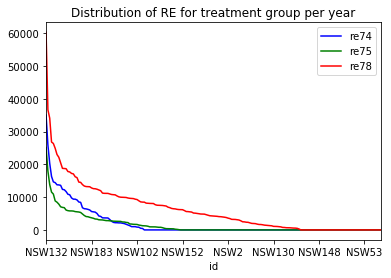

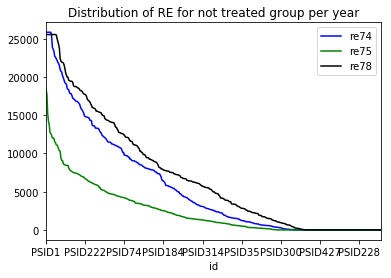

In [121]:
treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE for treatment group per year', legend=True)
treated['re75'].sort_values(ascending=False).plot(color='green', legend=True)
treated['re78'].sort_values(ascending=False).plot(color='red', legend=True)
plt.show()

not_treated['re74'].sort_values(ascending=False).plot(color='blue', title='Distribution of RE for not treated group per year', legend=True)
not_treated['re75'].sort_values(ascending=False).plot(color='green', legend=True)
not_treated['re78'].sort_values(ascending=False).plot(color='black', legend=True)
plt.show()

It would seem now (for the less naïve researcher) that the treatment actually works as we see the number of unemployed person (with real income = 0.0) decrease much faster in the treated group as in the other. To confirm this intuition let's print the amount of unemployed person in both groups.

In [107]:
print('Unemployed person in Treated group per year:\n',(treated[['re74', 're75', 're78']] == 0).astype(int).sum(axis=0))
print('Unemployed person in Not-treated group per year:\n',(not_treated[['re74', 're75', 're78']] == 0).astype(int).sum(axis=0))

Unemployed person in Treated group per year:
 re74    131
re75    111
re78     45
dtype: int64
Unemployed person in Not-treated group per year:
 re74    112
re75    134
re78     98
dtype: int64


The education level is very similar in both groups:

In [152]:
treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [153]:
not_treated['educ'].describe()

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

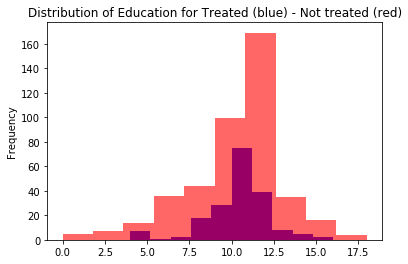

In [154]:
treated['educ'].plot(kind='hist', color='blue', title='Distribution of Education for Treated (blue) - Not treated (red)')
not_treated['educ'].plot(kind='hist', color='red', alpha=0.6)
plt.show()

People in the treatment group seem to be a little bit younger, but this could be explained the fact that younger people might be more willing to do training programs:

In [159]:
treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [160]:
not_treated['age'].describe()

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64

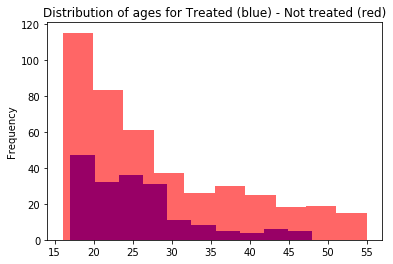

In [161]:
treated['age'].plot(kind='hist', color='blue', title='Distribution of ages for Treated (blue) - Not treated (red)')
not_treated['age'].plot(kind='hist', color='red', alpha=0.6)
plt.show()

In average people in the training programs tends to have a degree more often than in the other group:

In [163]:
treated['nodegree'].describe()

count    185.000000
mean       0.708108
std        0.455867
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

In [164]:
not_treated['nodegree'].describe()

count    429.000000
mean       0.596737
std        0.491126
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

### 1.3. A propensity score model

In [168]:
logistic = linear_model.LogisticRegression()
X = lalonde_df[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']]
y = lalonde_df['treat']
#training logistic model
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Here is the propensity score (probability of belonging to the class 0 or 1)

In [170]:
prop_score = logistic.predict_proba(X)
prop_score

array([[ 0.54192649,  0.45807351],
       [ 0.84801994,  0.15198006],
       [ 0.24903448,  0.75096552],
       ..., 
       [ 0.89944167,  0.10055833],
       [ 0.44954653,  0.55045347],
       [ 0.79880343,  0.20119657]])

### 1.4. Balancing the dataset via matching